<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/proper_customize_human_in_the_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community

In [28]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('langchain')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain"

gemini_api_key = userdata.get('GOOGLE_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get("Tavily_Api_Key")


In [29]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)
llm.invoke("greeting me")

AIMessage(content='Hello there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ae8cc8a3-0878-423e-822f-1f1dd54b3187-0', usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})

In [30]:
from langchain_community.tools.tavily_search import TavilySearchResults # Import the necessary class

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("what is current weather in karachi?")


[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1733298838, 'localtime': '2024-12-04 12:53'}, 'current': {'last_updated_epoch': 1733298300, 'last_updated': '2024-12-04 12:45', 'temp_c': 28.3, 'temp_f': 82.9, 'is_day': 1, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/day/143.png', 'code': 1030}, 'wind_mph': 16.1, 'wind_kph': 25.9, 'wind_degree': 68, 'wind_dir': 'ENE', 'pressure_mb': 1017.0, 'pressure_in': 30.03, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 33, 'cloud': 0, 'feelslike_c': 27.3, 'feelslike_f': 81.2, 'windchill_c': 28.4, 'windchill_f': 83.0, 'heatindex_c': 27.4, 'heatindex_f': 81.3, 'dewpoint_c': 9.6, 'dewpoint_f': 49.3, 'vis_km': 4.5, 'vis_miles': 2.0, 'uv': 4.6, 'gust_mph': 18.9, 'gust_kph': 30.4}}"},
 {'url': 'https://www.timeanddate.com/weather/@1174872',
  'content': 'Weather in Karachi

In [67]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END  # Ensure END is imported
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, ToolMessage
from IPython.display import Image, display

# Initialize MemorySaver
memory = MemorySaver()

In [68]:
class naveed(TypedDict):
  messages : Annotated[list, add_messages]
  ask_human : bool

In [69]:
from pydantic import BaseModel
class RequestAssistant(BaseModel):
  '''
  im hafiz naveed uddin
  '''
  request:str


In [70]:
llm_with_tools = llm.bind_tools(tools + [RequestAssistant])

AttributeError: 'function' object has no attribute 'bind_tools'

In [71]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x790824e37ee0>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'RequestAssistant', 'description': 'im hafiz naveed uddin', 'parameters': {'properties': {'request': {'type': 'string'}}, 'required': ['request'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [72]:
response = llm_with_tools.invoke("what is langgraph ?")
print(response)


content='I am sorry, I do not have access to information about LangGraph.  The available tools do not provide information about this topic.\n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-546403a8-0f7f-40cd-8755-b9c4af8b9d0c-0' usage_metadata={'input_tokens': 117, 'output_tokens': 28, 'total_tokens': 145, 'input_token_details': {'cache_read': 0}}


In [73]:
def llm (state:naveed):
  response = llm_with_tools.invoke(state["messages"])
  ask_human = False
  if (response.tool_calls[0]["name"] == "RequestAssistant"): # Assuming "RequestAssistant-name-" is a typo
    ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [74]:
def create_response(response:str, AIMessage:AIMessage):
  return ToolMessage(content=response, tool_call_id=AIMessage)
def human_node(state:naveed):
  new_message = []
  if not isinstance(state["messages"][-1],ToolMessage):
    new_message.append(create_response(content = "no response from human"))
    return{"messages":new_message, "ask_human":False}

In [75]:
builder = StateGraph(naveed)
builder.add_node("llm",llm)
builder.add_node("tools",ToolNode(tools = tools))
builder.add_node("human_node",human_node)

In [76]:
def next_node(state: naveed):
  if state["ask_human"]:
    return "human_node"
  return tools_condition(state) # Assuming tools_condition function is used for tool node selection based on state

builder.add_edge(START, "llm")
#Instead of next_node as a keyword argument, pass the function directly
builder.add_conditional_edges("llm",next_node,{"human_node": "human_node", "tools": "tools", "END": END})
# Pass edge data using edge_data keyword argument
builder.add_edge("human_node","llm")
builder.add_edge("tools","llm")

In [96]:
graph=builder.compile(checkpointer=memory, interrupt_before=["human_node"])

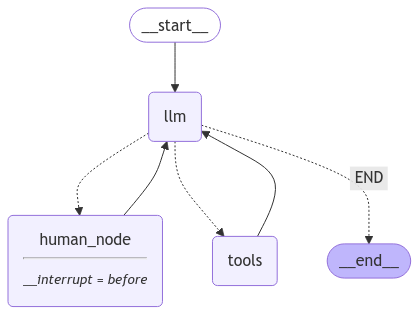

In [97]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [98]:
from langchain.schema.messages import ToolMessage, HumanMessage, AIMessage  # Import from langchain.schema.messages


In [99]:
config1 = {"configurable": {"thread_id": "1"}} # Changed config1 to a dictionary with the correct structure
message = graph.invoke({"messages":[HumanMessage(content = "I need some expert guidance for building this AI agent. Could you request assistance for me?")]}, config1)
for m in message["messages"]:
  m.pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistant (5ade1d6e-0040-41e0-bb46-7fccfeb97a64)
 Call ID: 5ade1d6e-0040-41e0-bb46-7fccfeb97a64
  Args:
    request: I need some expert guidance for building this AI agent.
================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistant (39990994-6f98-4f11-ac12-433aedfc3054)
 Call ID: 39990994-6f98-4f11-ac12-433aedfc3054
  Args:
    request: I need expert guidance on building an AI agent.
================================ Human Message =================================

I need some expert guidanc

In [100]:
snapshot=graph.get_state(config1)
snapshot.next

('human_node',)

In [101]:
m = snapshot.values["messages"][-1]
m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  RequestAssistant (1d35d3b4-2b28-43bd-afd7-47bf62d77c8e)
 Call ID: 1d35d3b4-2b28-43bd-afd7-47bf62d77c8e
  Args:
    request: I need expert guidance on building an AI agent.  Specifically, I need help with [mention specific areas needing help, e.g.,  architecture design, model selection, training data acquisition, etc.].


In [108]:
answer = ("Aigent is a software company that develops live voice AI solutions for contact centers. It helps clients in fintech, healthcare, and insurtech to improve customer service, prevent fraud, and train")
human_message = [
    ToolMessage(content= answer, tool_call_id=m.tool_calls[0]["id"]),
    AIMessage(content=answer)
]
human_message[-2]
graph.update_state(config1,{"messages":human_message})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb21c0-ac20-6c63-8008-4d942a74dee9'}}

In [110]:
for m in graph.get_state(config1).values["messages"]: # Changed "messaages" to "messages"
  m.pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistant (5ade1d6e-0040-41e0-bb46-7fccfeb97a64)
 Call ID: 5ade1d6e-0040-41e0-bb46-7fccfeb97a64
  Args:
    request: I need some expert guidance for building this AI agent.
================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistant (39990994-6f98-4f11-ac12-433aedfc3054)
 Call ID: 39990994-6f98-4f11-ac12-433aedfc3054
  Args:
    request: I need expert guidance on building an AI agent.
================================ Human Message =================================

I need some expert guidanc